In [88]:
import torch 
from torch import nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms as T
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import albumentations as A
from torchvision import io as read_image
from torchsummary import summary
import glob
import os
import sys
import cv2

In [4]:
path_clean = 'data/imgs'
# path_noisy = 'imgs'

In [5]:
clean_fl = glob.glob(path_clean+'/clean/*')
# noisy_fl = glob.glob(path_noisy)

In [321]:
noising = A.Compose([
            # A.transforms.Blur(always_apply=False, p=.2),
            # A.transforms.GaussNoise(var_limit=(0, .02), 
            #                         always_apply=False, p=.2),
            A.transforms.RandomFog(fog_coef_lower=1, fog_coef_upper=1, 
                                   alpha_coef=0.4, 
                                   always_apply=False, p=0.5),
            A.transforms.RandomShadow(shadow_roi=(0, 0, 1, 1), num_shadows_lower=1, 
                                      num_shadows_upper=2, shadow_dimension=2, 
                                      always_apply=False, p=0.9),
            A.transforms.RandomSnow(snow_point_lower=0.01, snow_point_upper=0.1, 
                                    brightness_coeff=0.5, 
                                    always_apply=False, p=0.9)
        ])

In [322]:
for img in clean_fl:
    image = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)
    noised_image = noising(image=cv2.cvtColor(cv2.imread(clean_fl[1]), cv2.COLOR_BGR2RGB))
    cv2.imwrite('data/imgs/dirty'+img[img.rfind('/'):], noised_image['image'])

In [301]:
image = cv2.cvtColor(cv2.imread(clean_fl[1]), cv2.COLOR_BGR2RGB)
noised_image = noising(image=cv2.cvtColor(cv2.imread(clean_fl[1]), cv2.COLOR_BGR2RGB))

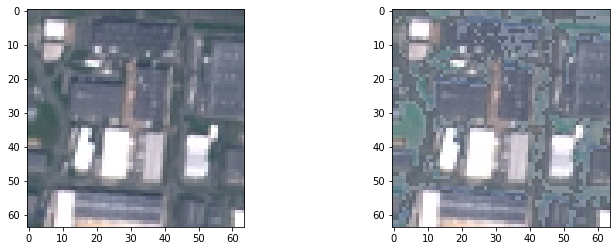

In [302]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].imshow(image)
ax[1].imshow(noised_image['image'])

In [63]:
trnsfrms = T.Compose([
    T.ToTensor(),
    # T.Normalize((.5, .5, .5), (1, 1, 1))
])
clean_dataset = ImageFolder('imgs/clean', transform=trnsfrms)
dirty_dataset = ImageFolder('imgs/dirty', transform=trnsfrms)

In [64]:
batch_size=32
clean_dl = DataLoader(clean_dataset, batch_size=batch_size)
dirty_dl = DataLoader(dirty_dataset, batch_size=batch_size)

In [92]:
class DenoisingBaseLine(nn.Module):
    def __init__(self):
        super().__init__()


        # encoder
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 128, 3),
            nn.Tanh()            
        )
        self.pool1 = nn.MaxPool2d(2, return_indices=True)

        self.conv2 = nn.Sequential(
            nn.Conv2d(128, 32, 2),
            nn.LeakyReLU()
        )

        self.pool2 = nn.MaxPool2d(2, return_indices=True)

        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 16, 2),
            nn.LeakyReLU()
        )


        # decoder

        self.upsample3 = nn.Sequential(
            nn.ConvTranspose2d(16, 32, 2),
            nn.Sigmoid()
        )

        self.unpool2 = nn.MaxUnpool2d(2)
        self.upsample2 = nn.Sequential(
            nn.ConvTranspose2d(32, 128, 2),
            nn.LeakyReLU()
        )
        self.unpool1 = nn.MaxUnpool2d(2)
        self.upsample1 = nn.Sequential(
            nn.ConvTranspose2d(128, 3, 3),
            nn.Sigmoid()
            
        )


    def forward(self, x):

        x = self.conv1(x)
        x, ind_1 = self.pool1(x)
        x = self.conv2(x)

        x, ind_2 = self.pool2(x)

        x = self.conv3(x)

        # print(x.shape)
        x = self.upsample3(x)
        x = self.unpool2(x, ind_2)
        x = self.upsample2(x)
        x = self.unpool1(x, ind_1)
        x = self.upsample1(x)
        
        # print(x.shape)
        return x


model = DenoisingBaseLine()

summary(model, (3, 64, 64))

# model

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 62, 62]           3,584
              Tanh-2          [-1, 128, 62, 62]               0
         MaxPool2d-3  [[-1, 128, 31, 31], [-1, 128, 31, 31]]               0
            Conv2d-4           [-1, 32, 30, 30]          16,416
         LeakyReLU-5           [-1, 32, 30, 30]               0
         MaxPool2d-6  [[-1, 32, 15, 15], [-1, 32, 15, 15]]               0
            Conv2d-7           [-1, 16, 14, 14]           2,064
         LeakyReLU-8           [-1, 16, 14, 14]               0
   ConvTranspose2d-9           [-1, 32, 15, 15]           2,080
          Sigmoid-10           [-1, 32, 15, 15]               0
      MaxUnpool2d-11           [-1, 32, 30, 30]               0
  ConvTranspose2d-12          [-1, 128, 31, 31]          16,512
        LeakyReLU-13          [-1, 128, 31, 31]               0
      MaxUnpool

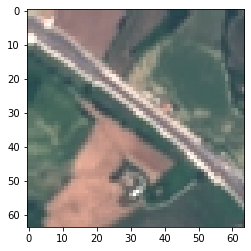

In [78]:
plt.imshow(next(iter(clean_dl))[0][0].permute(1, 2, 0).numpy())

In [93]:
n_epochs = 30
optimizer = torch.optim.Adagrad(model.parameters())
loss_fn = torch.nn.HuberLoss()


Epoch: 0 finished MSE: 0.018525707553241663


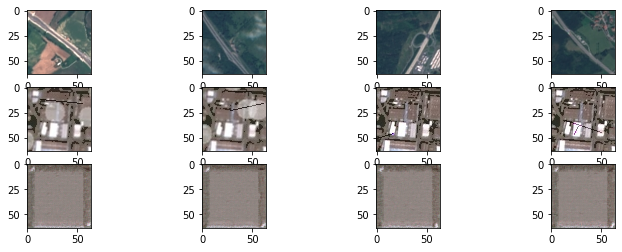

In [96]:
epoch_losses = []
for epoch in range(n_epochs):
    model.train()
    batch_losses = []
    for (dirty, _), (clean, _) in zip(clean_dl, dirty_dl):
        output = model(dirty)

        loss = loss_fn(output, clean)
        batch_losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_losses.append(np.mean(batch_losses))
    print(f'Epoch: {epoch} finished MSE: {np.mean(epoch_losses)}')
    model.eval()
    fig, ax = plt.subplots(3, 4, figsize=(16, 6))
    ax[0, 0].imshow(next(iter(clean_dl))[0][0].permute(1, 2, 0).numpy())
    ax[0, 1].imshow(next(iter(clean_dl))[0][1].permute(1, 2, 0).numpy())
    ax[0, 2].imshow(next(iter(clean_dl))[0][2].permute(1, 2, 0).numpy())
    ax[0, 3].imshow(next(iter(clean_dl))[0][3].permute(1, 2, 0).numpy())
    ax[1, 0].imshow(next(iter(dirty_dl))[0][0].permute(1, 2, 0).detach().numpy())
    ax[1, 1].imshow(next(iter(dirty_dl))[0][1].permute(1, 2, 0).detach().numpy())
    ax[1, 2].imshow(next(iter(dirty_dl))[0][2].permute(1, 2, 0).detach().numpy())
    ax[1, 3].imshow(next(iter(dirty_dl))[0][3].permute(1, 2, 0).detach().numpy())
    ax[2, 0].imshow(model(next(iter(clean_dl))[0])[0].permute(1, 2, 0).detach().numpy())
    ax[2, 1].imshow(model(next(iter(clean_dl))[0])[1].permute(1, 2, 0).detach().numpy())
    ax[2, 2].imshow(model(next(iter(clean_dl))[0])[2].permute(1, 2, 0).detach().numpy())
    ax[2, 3].imshow(model(next(iter(clean_dl))[0])[3].permute(1, 2, 0).detach().numpy())
    plt.show()

In [48]:
epoch_losses

[0.07514339120714528, 0.04969002408491578]